<a href="https://colab.research.google.com/github/Shamanthp2001/Shamanthp2001/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
torch.set_num_threads(4)

In [ ]:
train = pd.read_csv('/content/sample_data/train.csv.zip', dtype={"acoustic_data": np.float32, "time_to_failure": np.float32})
#train1 = pd.read_csv('/content/sample_data/sample1.csv', dtype={"acoustic_data": np.float32, "time_to_failure": np.float32})
#train2= pd.read_csv('/content/sample_data/sample_submission (1).csv', dtype={"acoustic_data": np.float32, "time_to_failure": np.float32})
#train=merged_data = train1.merge(train2,on=["Security Code"])
#merged_data.head()


In [ ]:
#t1=pd.read_csv('/content/sample_data/sample1 (1).csv')
#t2=pd.read_csv('/content/sample_data/sample_submission (1).csv')
#train=pd.concat([t1,t2])
train.head()

,acoustic_data,time_to_failure
0,12.0,1.4691
1,6.0,1.4691
2,8.0,1.4691
3,5.0,1.4691
4,8.0,1.4691


In [ ]:
print(train.shape)

(1048575, 2)


In [ ]:
#t1.head()
#t2.head()

,acoustic_data
0,7
1,0
2,-2
3,-4
4,0


In [ ]:
print(train.head())
train.tail()


   acoustic_data  time_to_failure
0           12.0           1.4691
1            6.0           1.4691
2            8.0           1.4691
3            5.0           1.4691
4            8.0           1.4691


,acoustic_data,time_to_failure
1048570,1.0,1.197796
1048571,10.0,1.197796
1048572,7.0,1.197796
1048573,8.0,1.197796
1048574,10.0,1.197796


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


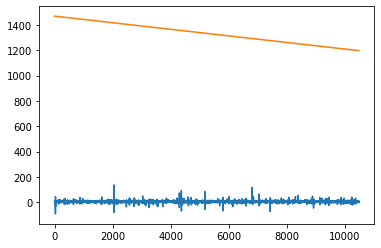

In [ ]:
sample_freq = 100
plt.plot(train.acoustic_data.values[::sample_freq])
plt.plot(train.time_to_failure.values[::sample_freq]*1000)

In [ ]:
def extract_features(z):
    return np.c_[
        z.mean(axis=1), 
        np.percentile(np.abs(z), q=[0, 25, 50, 75, 100], axis=1).T, 
        z.std(axis=1)
    ]

In [ ]:
def create_X(x, window_size=1000, sequence_len=150):
    tmp = x.reshape(sequence_len, -1)
    return np.c_[
        extract_features(tmp),
        extract_features(tmp[:, -window_size // 10:]),
        extract_features(tmp[:, -window_size // 100:])
    ]

In [ ]:
n_features = create_X(train.acoustic_data.values[0:150000]).shape[1]


In [ ]:
class TrainData(Dataset):
    def __init__(self, df, window_size=1000, sequence_len=150):
        self.rows = df.shape[0] // (window_size*sequence_len)
        self.data, self.labels = [], []
        for segment in range(self.rows):
            seg = df.iloc[segment*window_size*sequence_len: (segment+1)*window_size*sequence_len]
            x = seg.acoustic_data.values
            y = seg.time_to_failure.values[-1]
            self.data.append(create_X(x))
            self.labels.append(y)
    
    def __len__(self):
        return self.rows
    
    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.data[idx].astype(np.float32)),
            self.labels[idx]
        )

In [ ]:
train_data = TrainData(train)


In [ ]:
batch_size = 100
n_steps = len(train_data) #// 100
#print(n_steps)
#print(len(train_data))
#print(hidden_size)

6
6
32


In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        hidden = (
            torch.zeros(1, x.size(0), self.hidden_size),
            torch.zeros(1, x.size(0), self.hidden_size)
        )
        
        out, _ = self.lstm(x, hidden)
        
        out = self.fc(out[:, -1, :])
        return out.view(-1)

In [ ]:
input_size = n_features
hidden_size = 32
model = LSTM(input_size, hidden_size)

In [ ]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(100):
    for i, (data, labels) in enumerate(train_loader):
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'[Epoch {epoch}/2, Step {i}/{n_steps}]  loss: {loss.item(): .4f}')

[Epoch 0/2, Step 0/6]  loss:  0.0016
[Epoch 1/2, Step 0/6]  loss:  0.0016
[Epoch 2/2, Step 0/6]  loss:  0.0015
[Epoch 3/2, Step 0/6]  loss:  0.0015
[Epoch 4/2, Step 0/6]  loss:  0.0015
[Epoch 5/2, Step 0/6]  loss:  0.0014
[Epoch 6/2, Step 0/6]  loss:  0.0014
[Epoch 7/2, Step 0/6]  loss:  0.0014
[Epoch 8/2, Step 0/6]  loss:  0.0014
[Epoch 9/2, Step 0/6]  loss:  0.0013
[Epoch 10/2, Step 0/6]  loss:  0.0013
[Epoch 11/2, Step 0/6]  loss:  0.0013
[Epoch 12/2, Step 0/6]  loss:  0.0012
[Epoch 13/2, Step 0/6]  loss:  0.0012
[Epoch 14/2, Step 0/6]  loss:  0.0012
[Epoch 15/2, Step 0/6]  loss:  0.0012
[Epoch 16/2, Step 0/6]  loss:  0.0011
[Epoch 17/2, Step 0/6]  loss:  0.0011
[Epoch 18/2, Step 0/6]  loss:  0.0011
[Epoch 19/2, Step 0/6]  loss:  0.0011
[Epoch 20/2, Step 0/6]  loss:  0.0010
[Epoch 21/2, Step 0/6]  loss:  0.0010
[Epoch 22/2, Step 0/6]  loss:  0.0010
[Epoch 23/2, Step 0/6]  loss:  0.0010
[Epoch 24/2, Step 0/6]  loss:  0.0010
[Epoch 25/2, Step 0/6]  loss:  0.0009
[Epoch 26/2, Step 0/6]

3
